In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import keras
import glob
import cv2

import os
print(os.listdir("/Users/sriramreddy/Downloads/523/ex2/train/"))

/Users/sriramreddy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


['freshbanana', 'rottenbanana', 'freshoranges', 'freshapples', 'rottenoranges', 'rottenapples']


I've borrowed the code to grab the data from https://www.kaggle.com/gaborvecsei/fruit-juice-mix-of-pca-random-forest-svm to speed things up -- I'm focusing just on the neural network aspects of the project. Thank you user gaborvecsei!

I have borrowed the code to augment the data from https://medium.com/ymedialabs-innovation/data-augmentation-techniques-in-cnn-using-tensorflow-371ae43d5be9
 from the github link provided in that website. 
 (tensor flow inbuilt resize image)

## Data Resizing and Augmentation technique
## Training Set

In [2]:
fruit_images = []
labels = [] 
for fruit_dir_path in glob.glob("/Users/sriramreddy/Downloads/523/ex2/train/*"):
    fruit_label = fruit_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (110, 110))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
        #why do we need to convert the RGB2BGR
        #I don't think it is going to affect training
        #BGR was a choice made for historical reasons and now we have to live with it. In other words, BGR is the horse’s ass in OpenCV.
        fruit_images.append(image)
        labels.append(fruit_label)
fruit_images = np.array(fruit_images)
labels = np.array(labels)

In [3]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

In [4]:
id_to_label_dict

{0: 'freshapples',
 1: 'freshbanana',
 2: 'freshoranges',
 3: 'rottenapples',
 4: 'rottenbanana',
 5: 'rottenoranges'}

In [5]:
label_ids = np.array([label_to_id_dict[x] for x in labels])

In [6]:
fruit_images.shape, label_ids.shape, labels.shape

((10901, 110, 110, 3), (10901,), (10901,))

So, fruit_images contains our image files, label_ids has the numeric translation of our labels, and labels contains the name of the fruits themselves.

## Test Set:

The data provided calls this "validation", but we'll use it as our test set.

In [7]:
validation_fruit_images = []
validation_labels = [] 
for fruit_dir_path in glob.glob("/Users/sriramreddy/Downloads/523/ex2/test/*"):
    fruit_label = fruit_dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(fruit_dir_path, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (110, 110))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        validation_fruit_images.append(image)
        validation_labels.append(fruit_label)
validation_fruit_images = np.array(validation_fruit_images)
validation_labels = np.array(validation_labels)

In [8]:
validation_label_ids = np.array([label_to_id_dict[x] for x in validation_labels])

In [9]:
validation_fruit_images.shape, validation_label_ids.shape

((2698, 110, 110, 3), (2698,))

## Splitting the Data

In [10]:
X_train, X_test = fruit_images, validation_fruit_images
Y_train, Y_test = label_ids, validation_label_ids

#Normalize color values to between 0 and 1
X_train = X_train/255
X_test = X_test/255

#Make a flattened version for some of our models
X_flat_train = X_train.reshape(X_train.shape[0], 110*110*3)
X_flat_test = X_test.reshape(X_test.shape[0], 110*110*3)

#One Hot Encode the Output what is this 60 
Y_train = keras.utils.to_categorical(Y_train, 60)
Y_test = keras.utils.to_categorical(Y_test, 60)

print('Original Sizes:', X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print('Flattened:', X_flat_train.shape, X_flat_test.shape)

Original Sizes: (10901, 110, 110, 3) (2698, 110, 110, 3) (10901, 60) (2698, 60)
Flattened: (10901, 36300) (2698, 36300)


(110, 110, 3)


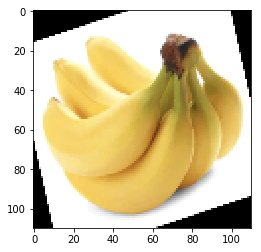

In [11]:
print(X_train[200].shape)
plt.imshow(X_train[0])
plt.show()

Cool! We've got all our images stored as 110* 110 pixel images with 3 channels for RGB, as well as a flattened version for certain models. Let's start with a simple sequential model.

## Setting Up Our Neural Network

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop, SGD

# Import the backend
from keras import backend as K

## Run a Quick Model 

In [13]:
model_dense = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model_dense.add(Dense(128, activation='relu', input_shape=(X_flat_train.shape[1],)))
# Dropout layers remove features and fight overfitting
model_dense.add(Dropout(0.1))
model_dense.add(Dense(64, activation='relu'))
model_dense.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model_dense.add(Dense(60, activation='softmax'))
model_dense.summary()
# Compile the model to put it all together.
#categorical_crossentropy loss
model_dense.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

#Changed the batch size here
history_dense = model_dense.fit(X_flat_train, Y_train,
                          batch_size=50,
                          epochs=10,
                          verbose=1,
                          validation_data=(X_flat_test, Y_test))
score = model_dense.evaluate(X_flat_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               4646528   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3900      
Total params: 4,658,684
Trainable params: 4,658,684
Non-trainable params: 0
_________________________________________________________________
Train on 10901 samples, validate on 2698 samples
Epoch 1/10
10901/10901 [==============================] - 64s 6ms/step - loss: 13.1

Great! That's a good starting point. We're achieving ~16% accuracy on the test set using a neural network with two dense layers (128 nodes and 64 nodes) and dropout (to reduce overfitting). Let's see how much better we can do, first using a deeper network, and then using CNN.

In [14]:
model_deep = Sequential()
# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model_deep.add(Dense(256, activation='relu', input_shape=(X_flat_train.shape[1],)))
# Dropout layers remove features and fight overfitting
model_deep.add(Dropout(0.05))
model_deep.add(Dense(128, activation='relu'))
model_deep.add(Dropout(0.05))
model_deep.add(Dense(128, activation='relu'))
model_deep.add(Dropout(0.05))
model_deep.add(Dense(128, activation='relu'))
model_deep.add(Dropout(0.05))
model_deep.add(Dense(128, activation='relu'))
model_deep.add(Dropout(0.05))
# End with a number of units equal to the number of classes we have for our outcome
model_deep.add(Dense(60, activation='softmax'))

model_deep.summary()

# Compile the model to put it all together.
model_deep.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

history_deep = model_deep.fit(X_flat_train, Y_train,
                          batch_size=50,
                          epochs=10,
                          verbose=1,
                          validation_data=(X_flat_test, Y_test))
score = model_deep.evaluate(X_flat_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               9293056   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
__________

In [3]:
#The network results in very less accuracy if you are using only RELU layers as it is unable to capture the features.

In [16]:
#there are using maxpool convolution and final dense layer.
model_cnn = Sequential()
# First convolutional layer, note the specification of shape
model_cnn.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(110, 110, 3)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(60, activation='softmax'))

model_cnn.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_cnn.fit(X_train, Y_train,
          batch_size=128,
          epochs=1,
          verbose=1,
          validation_data=(X_test, Y_test))
score = model_cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 10901 samples, validate on 2698 samples
Epoch 1/1
10901/10901 [==============================] - 564s 52ms/step - loss: 1.9528 - acc: 0.4328 - val_loss: 1.7006 - val_acc: 0.4566
Test loss: 1.700645467234683
Test accuracy: 0.45663454410674575


Normally I wouldn't leave this trial run in the notebook, but our CNN got up to 45% accuracy on a single epoch! Let's run it for a few more and see how well we can do.

In [17]:
model_cnn.fit(X_train, Y_train,
          batch_size=128,
          epochs=30,
          verbose=1,
          validation_data=(X_test, Y_test))
score = model_cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 10901 samples, validate on 2698 samples
Epoch 1/30
10901/10901 [==============================] - 592s 54ms/step - loss: 0.7617 - acc: 0.7367 - val_loss: 0.5992 - val_acc: 0.7880
Epoch 2/30
10901/10901 [==============================] - 2070s 190ms/step - loss: 0.5316 - acc: 0.8110 - val_loss: 0.3077 - val_acc: 0.8984
Epoch 3/30
10901/10901 [==============================] - 2211s 203ms/step - loss: 0.4182 - acc: 0.8576 - val_loss: 0.3225 - val_acc: 0.8747
Epoch 4/30
10901/10901 [==============================] - 544s 50ms/step - loss: 0.3665 - acc: 0.8704 - val_loss: 0.2517 - val_acc: 0.9122
Epoch 5/30
10901/10901 [==============================] - 542s 50ms/step - loss: 0.3054 - acc: 0.8904 - val_loss: 0.8082 - val_acc: 0.7168
Epoch 6/30
10901/10901 [==============================] - 13288s 1s/step - loss: 0.2782 - acc: 0.9007 - val_loss: 0.3626 - val_acc: 0.8747
Epoch 7/30
10901/10901 [==============================] - 19782s 2s/step - loss: 0.2358 - acc: 0.9158 - val_loss:

Excellent! Deepening the network (now five hidden layers: 256, 128, 128, 128, 128) brought the test set accuracy from 77% (Multi class SVM) to 94%! On to CNN -- we expect this to do the best but take significantly longer. 
This is a great result -- we can identify fruits!

In [18]:
'''model_cnn.fit(X_train, Y_train,
          batch_size=128,
          epochs=15,
          verbose=1,
          validation_data=(X_test, Y_test))
score = model_cnn.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])'''

"model_cnn.fit(X_train, Y_train,\n          batch_size=128,\n          epochs=15,\n          verbose=1,\n          validation_data=(X_test, Y_test))\nscore = model_cnn.evaluate(X_test, Y_test, verbose=0)\nprint('Test loss:', score[0])\nprint('Test accuracy:', score[1])"

In [19]:
fname="/Users/sriramreddy/Downloads/523/ex2/weights_cnn_classification_augmented_data.hdf5"
model_cnn.save_weights(fname,overwrite=True)
#In future, you can use this model and later you can load this model for prediction 